In [ ]:
import numpy as np  # Linear algebra
import pandas as pd  # Data processing, CSV file I/O (e.g., pd.read_csv)
import os
import matplotlib.pyplot as plt  # Matplotlib for visualization
plt.style.use("ggplot")

import cv2  # OpenCV Image Library

# Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

# Set the base directory for data
base_dir = './input/'
print(os.listdir(base_dir))

['histopathologic-cancer-detection (1).zip', 'sample_submission.csv', 'test', 'train', 'train_labels.csv']


In [ ]:
# Read the CSV file into a DataFrame
full_train_df = pd.read_csv("./input/train_labels.csv")

# Display the first few rows of the DataFrame
print(full_train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [ ]:
# Get the number of files in the train and test directories
train_size = len(os.listdir('./input/train/'))
test_size = len(os.listdir('./input/test/'))

# Print the sizes
print("Train Size: {}".format(train_size))
print("Test Size: {}".format(test_size))

Train Size: 220025
Test Size: 57458


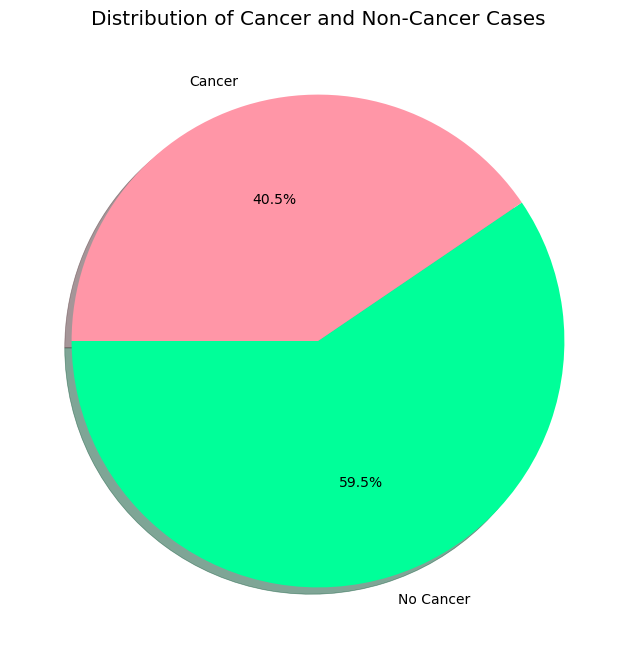

In [ ]:
# Count the occurrences of each label in the 'label' column
labels_count = full_train_df['label'].value_counts()

# Set up pie chart parameters
colors = ['#00ff99', '#FF96A7']
labels = ['No Cancer', 'Cancer']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(labels_count, labels=labels, startangle=180, autopct='%1.1f%%', colors=colors, shadow=True)
plt.title('Distribution of Cancer and Non-Cancer Cases')
plt.show()

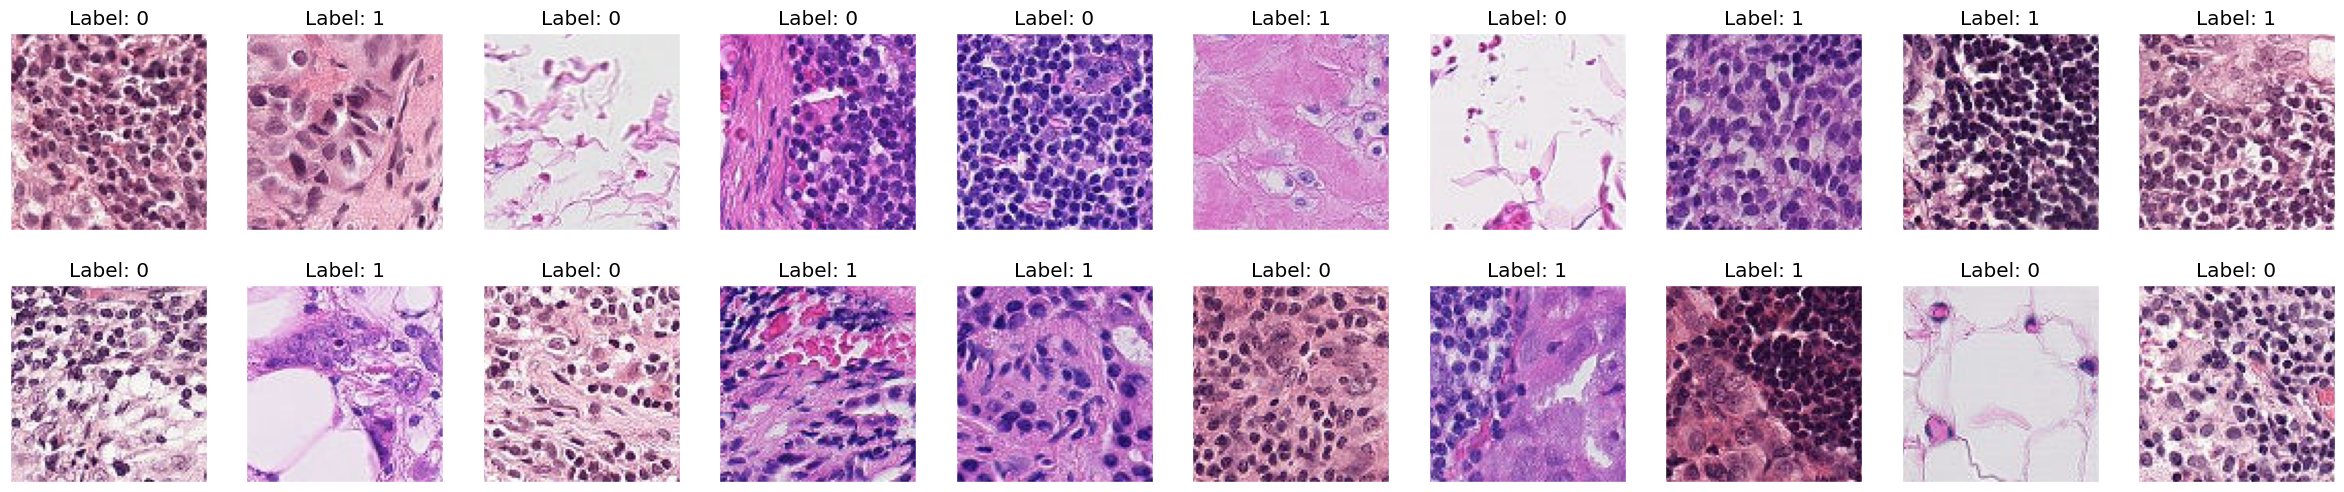

In [ ]:
# Set up the figure to display 20 images
fig = plt.figure(figsize=(30, 6))

# Get a list of 20 random image filenames from the 'train' directory
train_imgs = np.random.choice(os.listdir(base_dir + "train"), 20)

# Iterate through the selected images
for idx, img in enumerate(train_imgs):
    # Create subplots for each image
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])

    # Open and display the image
    im = Image.open(os.path.join(base_dir, "train", img))
    plt.imshow(im)

    # Get the corresponding label from the DataFrame
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]

    # Set the title of the subplot with the label information
    ax.set_title('Label: %s' % lab)

# Show the figure
plt.show()

In [ ]:
# Define the desired number of samples for each class
SAMPLE_SIZE = 80000

# Set the paths for the train and test data
train_path = './input/train/'
test_path = './input/test/'

# Select 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dataframes and shuffle them
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

# Print the shape of the resulting dataframe
print("Shape of the resulting dataframe:", train_df.shape)

Shape of the resulting dataframe: (160000, 2)


In [ ]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='./', transform=None):
        """
        Args:
            df_data: DataFrame that contains image names and labels.
            data_dir: directory with all the images.
            transform: Optional transform to be applied on an image.
        """
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        Args:
            index: the index of the sample.

        Returns:
            A tuple (image, label).
        """
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')

        # Read image using OpenCV
        image = cv2.imread(img_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # You can uncomment and use your specific mean and std values if needed
    # transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [ ]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # You can uncomment and use your specific mean and std values if needed
    # transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Creating test data
sample_sub = pd.read_csv("./input/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# Prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional and Pooling Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.dropout2d = nn.Dropout2d()

        self.fc = nn.Sequential(
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Method for Forward Propagation."""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: {}".format(pytorch_total_params))

Number of trainable parameters: 6805249


In [ ]:
# Specify loss function (binary cross-entropy loss)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [ ]:
# Number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# Keeping track of losses and metrics
train_losses = []
valid_losses = []
val_auc = []
auc_epoch = []

# Training loop
for epoch in range(1, n_epochs + 1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()  # Convert target to float
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss
        train_loss += loss.item() * data.size(0)

    ######################
    # Validate the model #
    ######################
    model.eval()
    val_auc = []
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()  # Convert target to float
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss
        valid_loss += loss.item() * data.size(0)
        # Calculate AUC
        y_actual = target.data.cpu().numpy()
        y_pred = output[:, -1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))

    # Calculate average losses and AUC
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print training/validation statistics
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))

    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.366004 | Validation Loss: 0.296835 | Validation AUC: 0.9465
Validation loss decreased (inf --> 0.296835).  Saving model ...
Epoch: 2 | Training Loss: 0.289644 | Validation Loss: 0.291281 | Validation AUC: 0.9584
Validation loss decreased (0.296835 --> 0.291281).  Saving model ...
Epoch: 3 | Training Loss: 0.257443 | Validation Loss: 0.262918 | Validation AUC: 0.9678
Validation loss decreased (0.291281 --> 0.262918).  Saving model ...
Epoch: 4 | Training Loss: 0.230161 | Validation Loss: 0.209332 | Validation AUC: 0.9739
Validation loss decreased (0.262918 --> 0.209332).  Saving model ...
Epoch: 5 | Training Loss: 0.213943 | Validation Loss: 0.334111 | Validation AUC: 0.9557
Epoch: 6 | Training Loss: 0.202031 | Validation Loss: 0.190346 | Validation AUC: 0.9780
Validation loss decreased (0.209332 --> 0.190346).  Saving model ...
Epoch: 7 | Training Loss: 0.195388 | Validation Loss: 0.187587 | Validation AUC: 0.9788
Validation loss decreased (0.190346 --> 0.18

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [ ]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
# Turn off gradients
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file
sample_sub['label'] = preds

In [ ]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i])

In [ ]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

In [ ]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal"
    ax.set_title('{}'.format(prob))